In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import plotting
from scipy.stats import norm

In [ ]:
# results = []
# results_dir = './20231005144659_sim_mar/results/'
# for filename in os.listdir(results_dir):
#     with open(f'{results_dir}/{filename}', 'rb') as f:
#         res = pickle.load(f).to_dict()
#         res.update(res['result'])
#         del res['result']
#         results.append(pd.Series(res))

# df = pd.DataFrame(results)
# with open('./20231005144659_sim_mar/results_all.pickle', 'wb') as f:
#     pickle.dump(df, f)

In [309]:
from pyfrechet.metric_spaces import log_cholesky

def log_chol_to_L(DL):
    n = DL.shape[0]
    d = int((-1 + np.sqrt(1 + 8 * n)) / 2)
    L = np.zeros(shape=(d,d))
    L[np.diag_indices(d)] = np.exp(DL[:d])
    L[np.tril_indices(d, -1)] = DL[d:]
    return L

def noise(x, s1, s2):
    C_eps = np.zeros_like(x)
    C_eps[:M.dim] = s1 * np.random.normal(size=M.dim)
    C_eps[M.dim:] = s2 * np.random.normal(size=x.shape[0] - M.dim)
    
    L_eps = log_chol_to_L(C_eps)
    x = log_cholesky.log_chol_to_spd(x)
    return log_cholesky.spd_to_log_chol(L_eps.dot(x).dot(L_eps.T))


M=log_cholesky.LogCholesky(10)
def sim(T, phi, mu, s1=0.5, s2=0.5):
    def geodesic(x, theta, mu):
        return theta * x + (1-theta)*mu
    
    x = np.zeros((T, mu.shape[0])) + mu
    for i in range(1,T):
        x[i, :] = geodesic(x[i-1], phi, mu)
        # # log-normal noise on eigenvalues
        # x[i, :M.dim] += s1 * np.random.normal(size=M.dim)
        # # normal noise on the lower-triangular elements
        # x[i, M.dim:] += s2 * np.random.normal(size=mu.shape[0] - M.dim)

        x[i, :] = noise(x[i,:], s1, s2)

    return x
    

mean = log_cholesky.spd_to_log_chol(np.eye(M.dim))



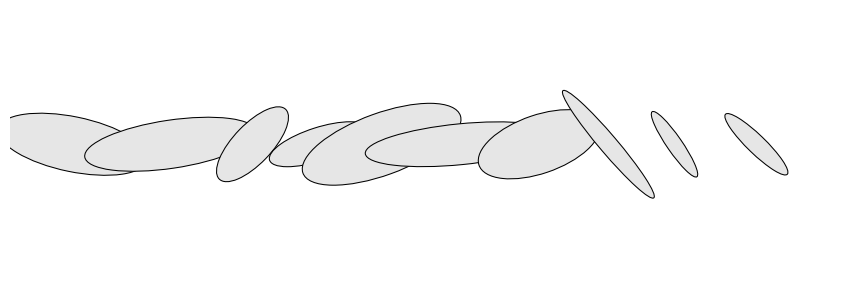

In [335]:
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance matrix (`cov`).
    """
    if ax is None:
        ax = plt.gca()

    # Decompose and sort the eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:,order]

    # Compute the angle between the x-axis and the largest eigenvector
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellipse = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_patch(ellipse)

np.random.seed(3)
x = sim(20, 0.8, mean, s1=0.2, s2=0.5)

n = 10
dx = np.array([0,1.55,1.3,1.05,1,1.25,1.25,1.1,1.05,1.3])
fc = 0.9

fig, ax = plt.subplots(figsize=(np.sum(dx),3.5))

for i in range(n):
    cov_matrix = log_cholesky.log_chol_to_spd(x[1+i, :])[:2, :2] / 10
    position = [np.cumsum(dx)[i], 0]
    plot_cov_ellipse(cov_matrix, position, ax=ax, label=i, facecolor=(fc,fc,fc), edgecolor='black', linewidth=0.75)

plt.xlim(-1,np.sum(dx)+1.5)
plt.ylim(-2,2)
plt.gca().set_axis_off()
# plt.gca().xaxis.set_visible(False)  

In [270]:

np.cumsum(dx)

array([ 1. ,  3.5,  6. ,  8.5, 11. , 13.5, 16. , 18.5, 21. , 23.5])

In [2]:
# 20231004145115_sim_mar
# 20231005144659_sim_mar

with open(f'./results/20240125112717_sim_mar/results_all.pickle', 'rb') as f:
    df_logchol = pickle.load(f)

with open(f'./results/20231004145115_sim_mar/results_all.pickle', 'rb') as f:
    df_ours = pickle.load(f)
    df_ours_w = df_ours[df_ours['sim_setup'] == 'wasserstein'].copy()
    df_ours_r = df_ours[df_ours['sim_setup'] == 'r'].copy()

with open(f'./results/20231005144659_sim_mar/results_all.pickle', 'rb') as f:
    df_ser_dep = pickle.load(f)
    df_ser_dep_w = df_ser_dep[df_ser_dep['sim_setup'] == 'wasserstein'].copy()
    df_ser_dep_r = df_ser_dep[df_ser_dep['sim_setup'] == 'r'].copy()


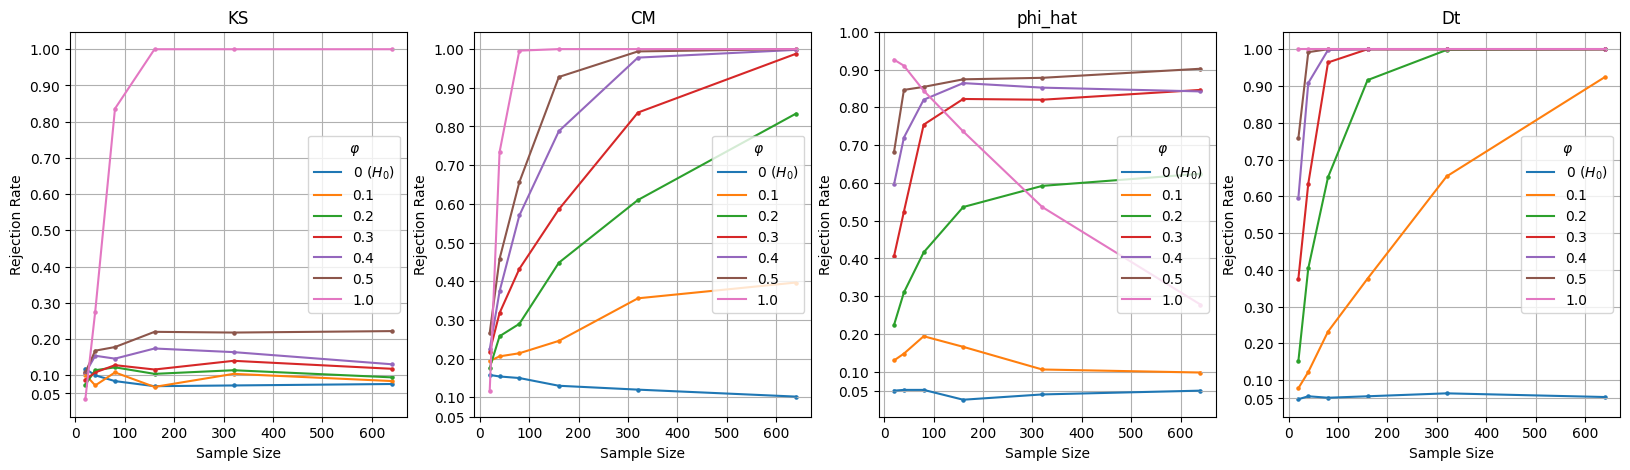

In [3]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_test_for(df_ser_dep_w, 'KS', onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_test_for(df_ser_dep_w, 'CM', onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_test_for(df_ours_w, 'phi_hat', onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_test_for(df_ours_w, 'Dt')

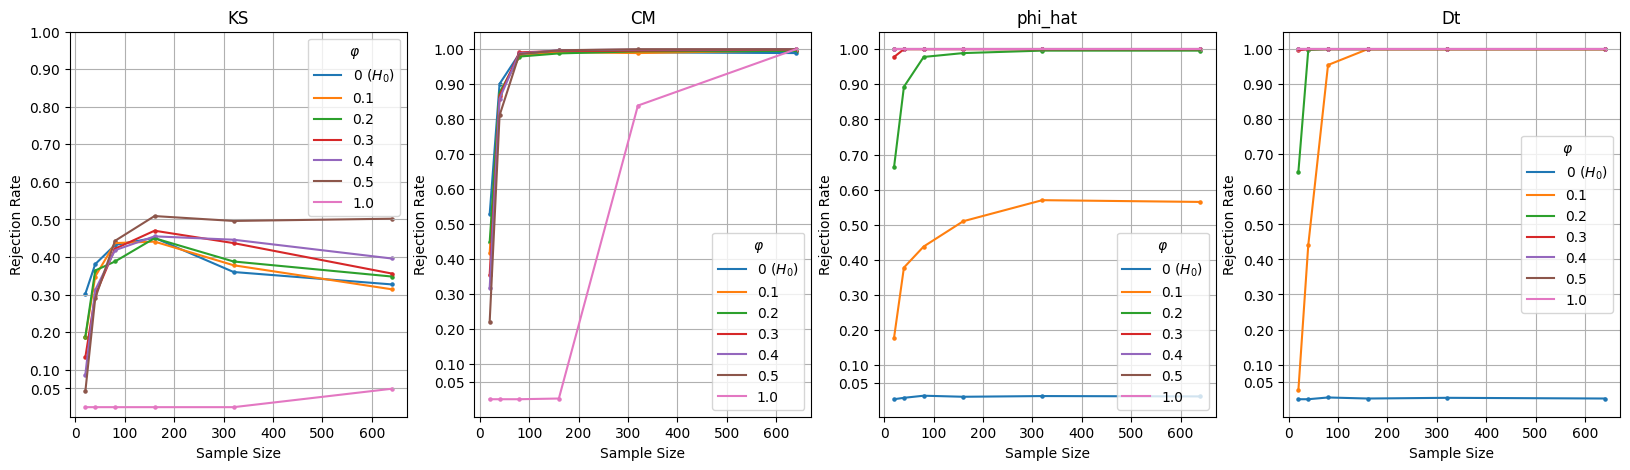

In [4]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_test_for(df_logchol, 'KS', onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_test_for(df_logchol, 'CM', onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_test_for(df_logchol, 'phi_hat', onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_test_for(df_logchol, 'Dt')

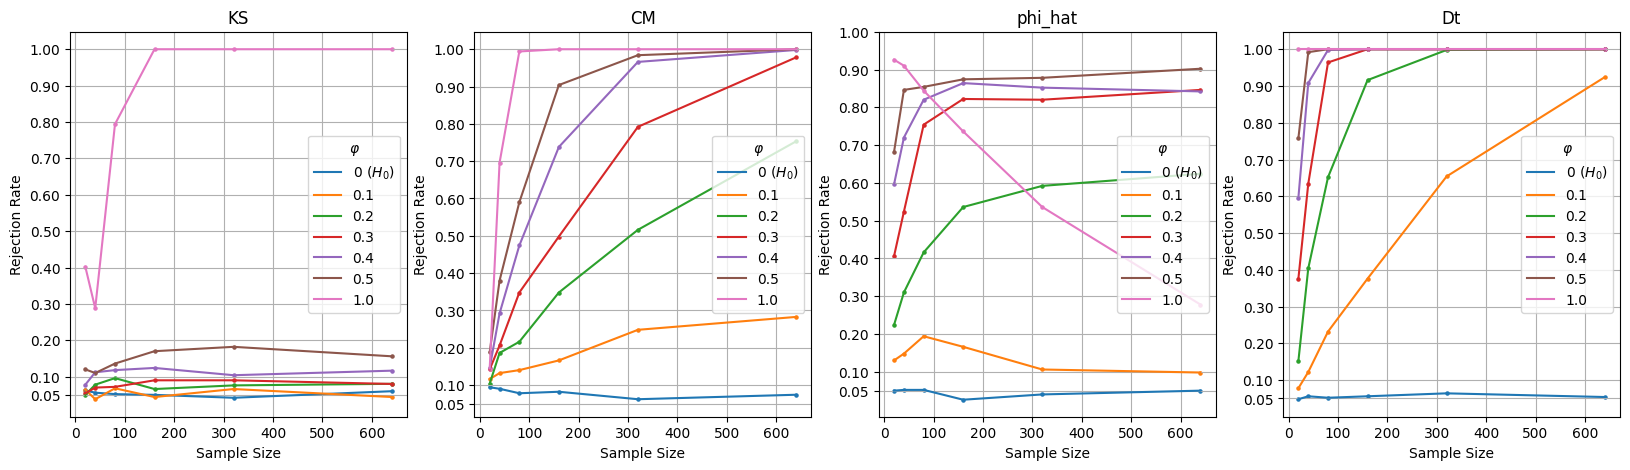

In [5]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_test_for(df_ser_dep_w, 'KS')
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_test_for(df_ser_dep_w, 'CM')


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_test_for(df_ours_w, 'phi_hat', onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_test_for(df_ours_w, 'Dt')

In [21]:
def plot_alpha_alpha(df, statname, samplesize, onesided=False):
    target_sizes = np.linspace(0, 0.1, 40)
    for phi in [0]: # np.sort(df.phi.unique()):
        sub_df = df[(df['sample_size'] == samplesize) & (df['phi'] == phi)]

        emp_sizes = np.zeros_like(target_sizes)
        for i in range(target_sizes.shape[0]):
            alpha=target_sizes[i]

            if onesided:
                crit = compute_critical_val(sub_df, f'quantiles_{statname}', 1-alpha)
                emp_sizes[i] = (sub_df[statname] > crit).mean()
            else:
                crit_lo = compute_critical_val(sub_df, f'quantiles_{statname}', alpha/2)
                crit_hi = compute_critical_val(sub_df, f'quantiles_{statname}', 1 - alpha/2)
                emp_sizes[i] = ((sub_df[statname] < crit_lo) | (sub_df[statname] > crit_hi)).mean()
            
        label = r'$0\ (H_0)$' + statname if phi == 0 else f'{phi:.1f}'
        plt.scatter(target_sizes, emp_sizes, label=label, s=5)

    
    plt.plot(target_sizes,target_sizes)
    plt.legend(title=r'$\varphi$')
    plt.xlabel('Test level')
    plt.ylabel('Rejection Rate')
    plt.grid('on')

samplesize = 320

plot_alpha_alpha(df_ser_dep_w, 'KS', samplesize, onesided=True)
plot_alpha_alpha(df_ser_dep_w, 'CM', samplesize, onesided=True)


plot_alpha_alpha(df_ours_w, 'phi_hat', samplesize, onesided=True)

plot_alpha_alpha(df_ours_w, 'Dt', samplesize)


NameError: name 'compute_critical_val' is not defined

In [16]:
df_logchol.sample_size.unique()

array([320,  80, 160, 640,  40,  20])

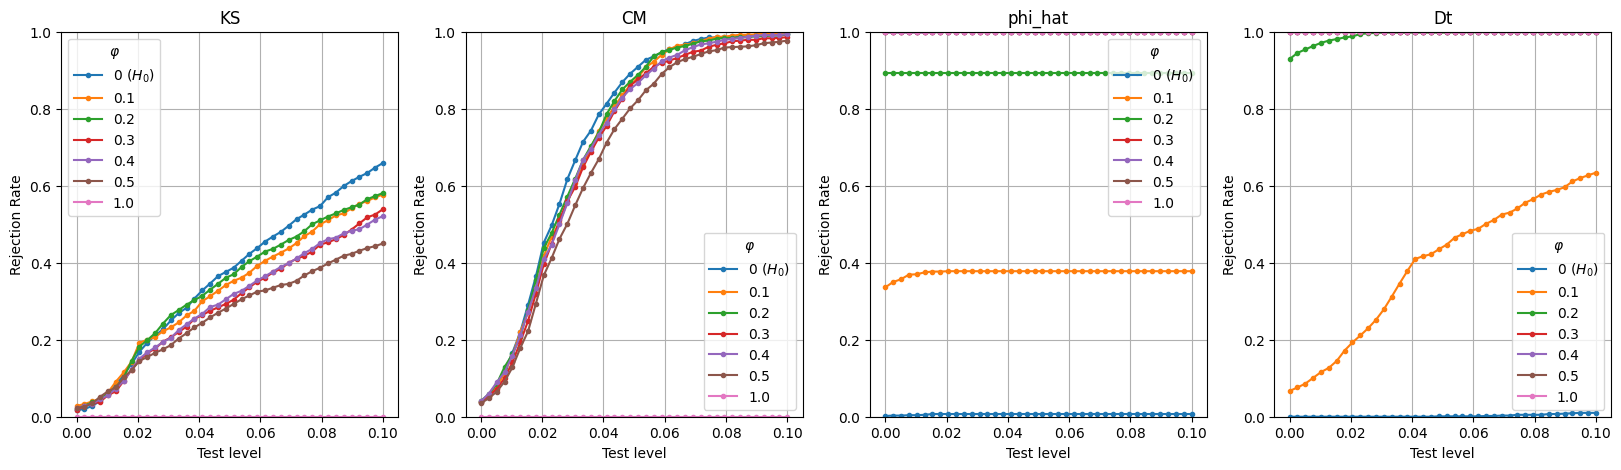

In [28]:

samplesize = 40

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_alpha_alpha(df_logchol, 'KS', samplesize, onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_alpha_alpha(df_logchol, 'CM', samplesize, onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_alpha_alpha(df_logchol, 'phi_hat', samplesize, onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_alpha_alpha(df_logchol, 'Dt', samplesize)


In [23]:
target_sizes = np.linspace(0, .1, 40)
for phi in np.sort(df_logchol.phi.unique()):
    sub_df = df_logchol[(df_logchol['sample_size'] == 320) & (df_logchol['phi'] == phi)]

    emp_sizes = np.zeros_like(target_sizes)
    for i in range(target_sizes.shape[0]):
        alpha=target_sizes[i]

        crit_lo = plotting.compute_critical_val(sub_df, f'quantiles_Dt', alpha/2)
        crit_hi = plotting.compute_critical_val(sub_df, f'quantiles_Dt', 1 - alpha/2)
        emp_sizes[i] = ((sub_df['Dt'] < crit_lo) | (sub_df['Dt'] > crit_hi)).mean()
    
    print(phi, emp_sizes)

0.0 [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.002
 0.002 0.002 0.003 0.003 0.005 0.005 0.005 0.005 0.005 0.005 0.006 0.006
 0.006 0.006 0.007 0.007 0.007 0.008 0.009 0.011 0.012 0.012 0.012 0.012
 0.012 0.012 0.012 0.012]
0.1 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.2 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.3 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.4 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.5 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1.0 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

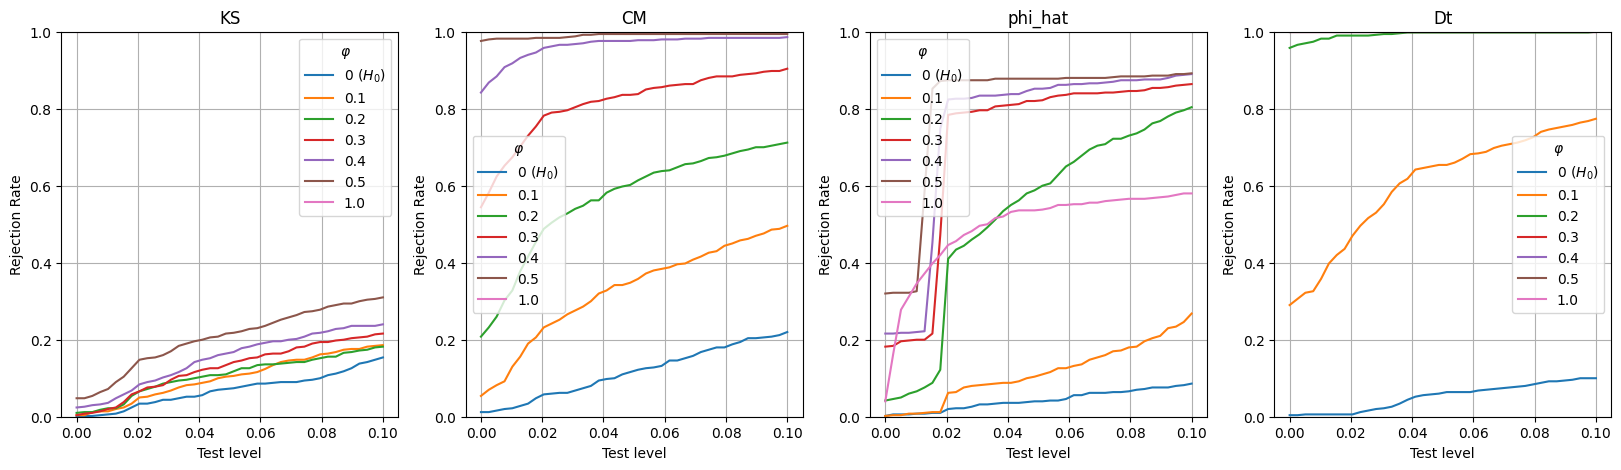

In [11]:

samplesize = 320

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_alpha_alpha(df_ser_dep_w, 'KS', samplesize, onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_alpha_alpha(df_ser_dep_w, 'CM', samplesize, onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_alpha_alpha(df_ours_w, 'phi_hat', samplesize, onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_alpha_alpha(df_ours_w, 'Dt', samplesize)


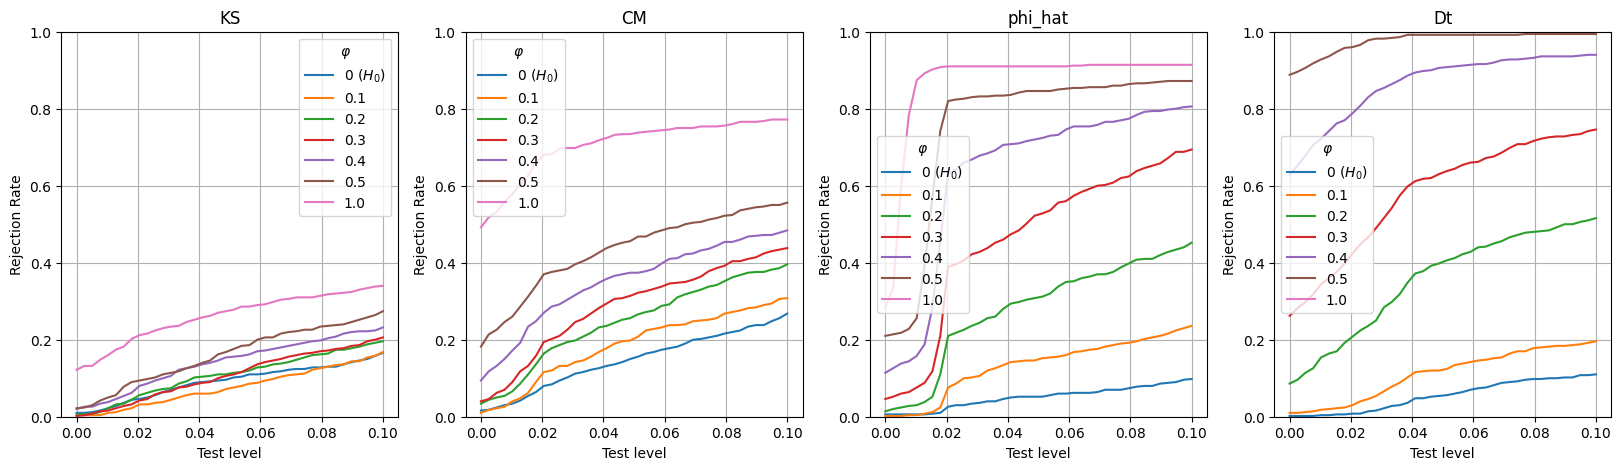

In [10]:
samplesize = 40

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_alpha_alpha(df_ser_dep_w, 'KS', samplesize, onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_alpha_alpha(df_ser_dep_w, 'CM', samplesize, onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_alpha_alpha(df_ours_w, 'phi_hat', samplesize, onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_alpha_alpha(df_ours_w, 'Dt', samplesize)

Text(0, 0.5, '$d(\\mu, \\hat\\mu)^2$')

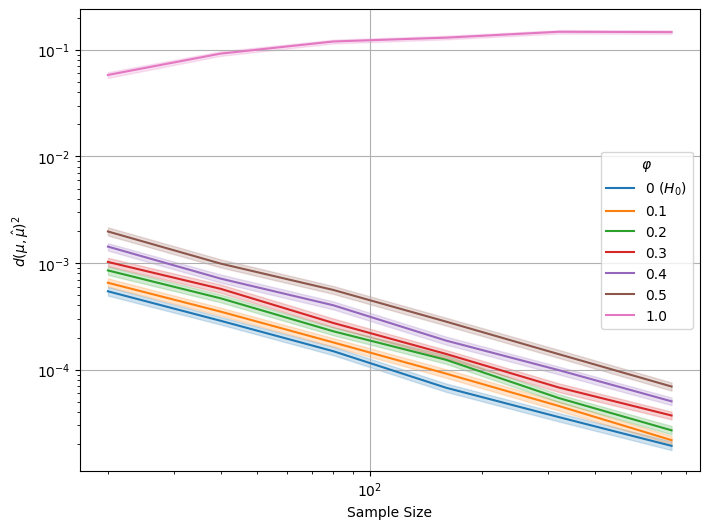

In [37]:
f, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")

for phi in np.sort(df_ours_w.phi.unique()):
    # if phi == 1:
    #     continue
    
    sub_df = _df[_df['phi'] == phi]

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='sample_size', y='err', label=label)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$d(\mu, \hat\mu)^2$')

Text(0, 0.5, '$\\left|\\hat\\varphi - \\varphi\\right|$')

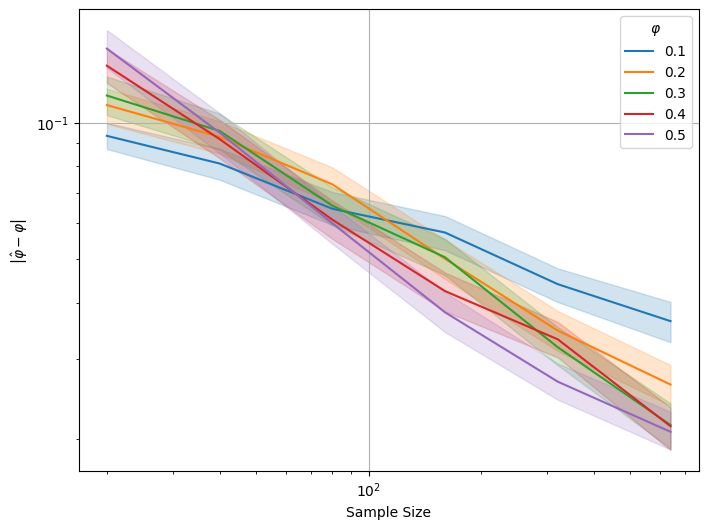

In [157]:
f, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")

for phi in np.sort(_df.phi.unique()):
    if phi == 0 or phi == 1:
        # ax.plot([], [], label=r'$0\ (H_0)$')
        continue
    sub_df = _df[_df['phi'] == phi].copy()
    sub_df['err_phi_hat'] = np.abs(sub_df['phi_hat'] - phi) + 1e-20

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='sample_size', y='err_phi_hat', label=label, ax=ax)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$\left|\hat\varphi - \varphi\right|$')

In [155]:
target_T = 100
true_size = np.linspace(0, 1, 40)

for phi in np.sort(_df['phi'].unique()):
    sub_df = _df[(_df['sample_size'] == target_T) & (_df['phi'] == phi)].copy()
    _M = sub_df.shape[0]

    rejection_rate = (np.repeat((np.abs(sub_df['Dt'] - sub_df['boot_mean_Dt']) / sub_df['boot_sig_Dt']).values,true_size.shape[0]).reshape((true_size.shape[0], _M)) > np.repeat(norm.ppf(1 - true_size/2), _M).reshape((true_size.shape[0], _M))).mean(axis=1)

    crit_Dt_lo = compute_critical_val(_df, 'quantiles_Dt', alpha/2)
    crit_Dt_hi = compute_critical_val(_df, 'quantiles_Dt', 1 - alpha/2)

    _df['rejected'] = (_df.Dt < crit_Dt_lo) | (_df.Dt > crit_Dt_hi)


    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    plt.scatter(true_size, rejection_rate, label=label, s=5)
plt.legend(title=r'$\varphi$')
plt.xlabel('Test level')
plt.ylabel('Empirical size')
plt.grid('on')


KeyError: 'boot_mean_Dt'